In [1]:
# Manipulação e Visualização de Dados
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, f1_score, recall_score

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import optuna
import joblib

c:\Users\hyggo\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df_train = pd.read_csv('../data/fold1_no_scale.csv')
df_val = pd.read_csv('../data/fold2_no_scale.csv')
df_test = pd.read_csv('../data/fold3_no_scale.csv')

In [3]:
TARGET = "Churn"

X_train, y_train = df_train.drop(columns=[TARGET]), df_train[TARGET]
X_val,   y_val   = df_val.drop(columns=[TARGET]),   df_val[TARGET]
X_test,  y_test  = df_test.drop(columns=[TARGET]),  df_test[TARGET]

In [4]:
feature_column_names = X_train.columns.tolist()

In [5]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
print("Acurácia Random Forest (validação):", accuracy_score(y_val, rf_preds))

# MLPClassifier
mlp_model = MLPClassifier(random_state=42,max_iter=1500)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_val)
print("Acurácia MLP (validação):", accuracy_score(y_val, mlp_preds))

# XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
print("Acurácia XGBoost (validação):", accuracy_score(y_val, xgb_preds))

Acurácia Random Forest (validação): 0.7768762677484787
Acurácia MLP (validação): 0.7870182555780934
Acurácia XGBoost (validação): 0.7834685598377282


In [6]:
# def compute_metric(metric, y_true, probs, preds):
#     """
#     Calcula o score de acordo com a métrica escolhida.
    
#     Parâmetros:
#       - metric: string ('ks', 'roc', 'accuracy', 'f1', 'recall')
#       - y_true: valores reais
#       - probs: probabilidades preditas (usadas para KS e ROC-AUC)
#       - preds: classes preditas (usadas para acurácia, F1 e recall)
      
#     Retorna:
#       - Valor da métrica escolhida.
#     """
#     if metric == 'ks':
#         return ks_2samp(probs[y_true == 1], probs[y_true == 0]).statistic
#     elif metric == 'roc':
#         fpr, tpr, thresholds = roc_curve(y_true, probs)
#         return auc(fpr, tpr)
#     elif metric == 'accuracy':
#         return accuracy_score(y_true, preds)
#     elif metric == 'f1':
#         return f1_score(y_true, preds)
#     elif metric == 'recall':
#         return recall_score(y_true, preds)
#     else:
#         raise ValueError("Métrica não suportada. Escolha entre 'ks', 'roc', 'accuracy', 'f1' ou 'recall'.")
    
# PARAM_SPACE = {
#     "rf": {
#         "n_estimators":           (50, 300,    "int"),
#         "max_depth":              (2, 80,     "int_log"),
#         "min_samples_split":      (2, 20,     "int"),
#         "min_samples_leaf":       (1, 20,     "int"),
#         "max_features":           (0.1, 1.0,  "float"),
#         "bootstrap":              [True, False],
#         "criterion":              ["gini", "entropy"],
#     },
#     "mlp": {
#         "hidden_layer_sizes":     [(50,), (100,), (50, 50), (100, 50), (100, 100)],
#         "activation":             ["relu", "tanh", "logistic"],
#         "solver":                 ["adam", "sgd"],
#         "alpha":                  (1e-5, 1e-2,    "float_log"),
#         "learning_rate_init":     (1e-7, 1e-1,    "float_log"),
#         "batch_size":             ["auto", 8, 16, 32, 64, 128],
#         "max_iter":               [ 500, 1000,1300,1500,2000],
#         "momentum":               (0.0, 0.99,     "float"),
#         "learning_rate":          ["constant", "invscaling", "adaptive"],
#         "tol":                    (1e-5, 1e-2,    "float_log"),
#     },
#     "xgb": {
#         "n_estimators":           (50, 300,    "int"),
#         "max_depth":              (2, 10,     "int_log"),
#         "learning_rate":          (1e-3, 0.3,  "float_log"),
#         "gamma":                  (0, 5,       "float"),
#         "subsample":              (0.5, 1.0,   "float"),
#         "colsample_bytree":       (0.5, 1.0,   "float"),
#         "reg_alpha":              (1e-5, 1e-1, "float_log"),
#         "reg_lambda":             (1e-5, 1e-1, "float_log"),
#     }
# }


# def get_objective(model_name, metric="ks"):
#     space = PARAM_SPACE[model_name]
#     def objective(trial):
#         # sugere tudo dinamicamente
#         kwargs = {}
#         for k,v in space.items():
#             if isinstance(v, tuple):
#                 low, high, kind = v
#                 if kind=="int":
#                     kwargs[k] = trial.suggest_int(k, low, high)
#                 elif kind=="int_log":
#                     kwargs[k] = trial.suggest_int(k, low, high, log=True)
#                 elif kind=="float":
#                     kwargs[k] = trial.suggest_float(k, low, high)
#                 elif kind=="float_log":
#                     kwargs[k] = trial.suggest_float(k, low, high, log=True)
#             else:
#                 # lista de choices
#                 kwargs[k] = trial.suggest_categorical(k, v)

#         # instancia o modelo
#         if model_name=="rf":
#             clf = RandomForestClassifier(random_state=42, **kwargs)
#             # fit & score
#             clf.fit(X_train, y_train)
#             probs = clf.predict_proba(X_val)[:,1]
#             preds = clf.predict(X_val)
#         elif model_name=="mlp":
#             clf = MLPClassifier(random_state=42, **kwargs)
#             scaler = StandardScaler()
#             X_train_scaled = scaler.fit_transform(X_train)
#             X_val_scaled = scaler.transform(X_val)
#             # fit & score
#             clf.fit(X_train_scaled, y_train)
#             probs = clf.predict_proba(X_val_scaled)[:,1]
#             preds = clf.predict(X_val_scaled)
#         else:  # xgb
#             clf = XGBClassifier(random_state=42, use_label_encoder=False,
#                                 eval_metric="logloss", **kwargs)
#             # fit & score
#             clf.fit(X_train, y_train)
#             probs = clf.predict_proba(X_val)[:,1]
#             preds = clf.predict(X_val)

#         return compute_metric(metric, y_val, probs, preds)
#     return objective

# for model in ["rf","mlp","xgb"]:
#     study = optuna.create_study(direction="maximize")
#     study.optimize(get_objective(model), n_trials=50)
#     print(model, "→ :best_params:", study.best_params, "| best_score:", study.best_value)
#     if model == "rf":
#         best_rf_params = study.best_params
#     elif model == "mlp":
#         best_mlp_params = study.best_params
#     elif model == "xgb":
#         best_xgb_params = study.best_params


In [7]:
best_rf_params = {'n_estimators': 181, 'max_depth': 80, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 0.14433895866314056, 'bootstrap': True, 'criterion': 'gini'}
best_mlp_params = {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00014922136338028723, 'learning_rate_init': 0.0013999067855568553, 'batch_size': 'auto', 'max_iter': 1000, 'momentum': 0.9079471829305951, 'learning_rate': 'constant', 'tol': 0.00279005126458061}
best_xgb_params = {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.06394426113769631, 'gamma': 4.250873077353954, 'subsample': 0.8098870915836598, 'colsample_bytree': 0.8381743726836992, 'reg_alpha': 0.001466473948922872, 'reg_lambda': 0.002877321235259522}

In [8]:
# best_rf_params = {'n_estimators': 132, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.22290137215315986, 'bootstrap': True, 'criterion': 'entropy'}
# best_mlp_params = {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 9.378890046495715e-05, 'learning_rate_init': 9.351095668258579e-06, 'batch_size': 16, 'max_iter': 1500, 'momentum': 0.7731362527089873, 'learning_rate': 'invscaling', 'tol': 4.0359613960011186e-05}
# best_xgb_params = {'n_estimators': 181,
#  'max_depth': 2,
#  'learning_rate': 0.034086900335549314,
#  'gamma': 1.6478134039856276,
#  'subsample': 0.6339990719450903,
#  'colsample_bytree': 0.6094061736031922,
#  'reg_alpha': 0.004519046789752244,
#  'reg_lambda': 0.0011747913628717445}

In [ ]:
import os
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


SAVE_DIR = '../models/'
os.makedirs(SAVE_DIR, exist_ok=True)

X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_val)
X_test_df  = pd.DataFrame(X_test)

y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_val)
y_test_df  = pd.DataFrame(y_test)

models = {
    "Random Forest": RandomForestClassifier(random_state=42, **best_rf_params),
    "MLP":           MLPClassifier(random_state=42, **best_mlp_params),
    "XGBoost":       XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_xgb_params)
}

folds = [
    {
        "X_train": pd.concat([X_train_df, X_valid_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_train_df, y_valid_df], axis=0).reset_index(drop=True),
        "X_test":  X_test_df.reset_index(drop=True),
        "y_test":  y_test_df.reset_index(drop=True)
    },
    {
        "X_train": pd.concat([X_valid_df, X_test_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_valid_df, y_test_df], axis=0).reset_index(drop=True),
        "X_test":  X_train_df.reset_index(drop=True),
        "y_test":  y_train_df.reset_index(drop=True)
    },
    {
        "X_train": pd.concat([X_test_df, X_train_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_test_df, y_train_df], axis=0).reset_index(drop=True),
        "X_test":  X_valid_df.reset_index(drop=True),
        "y_test":  y_valid_df.reset_index(drop=True)
    }
]

for i, fold in enumerate(folds, start=1):
    X_tr = fold["X_train"]
    y_tr = fold["y_train"].squeeze().values.ravel()

    print(f"\n=== Fold {i} ===")
    for name, model in models.items():
        model.fit(X_tr, y_tr)
        filename = os.path.join(SAVE_DIR, f'{name}_fold_{i}_model.joblib')
        joblib.dump(model, filename)
        print(f"Modelo '{name}' do Fold {i} salvo em: {filename}")



=== Fold 1 ===


c:\Users\hyggo\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Modelo 'Random Forest' do Fold 1 salvo como '../models/Random Forest_fold_1_model.joblib'
Random Forest | Acurácia = 0.8008 | AUC = 0.8436


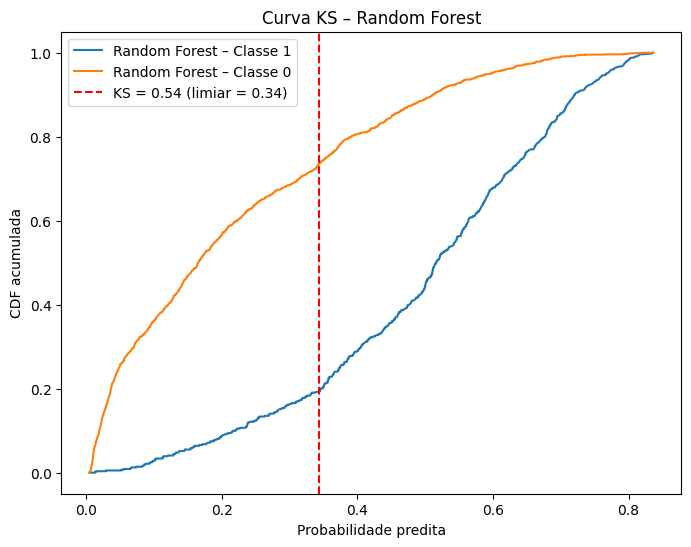

Modelo 'MLP' do Fold 1 salvo como '../models/MLP_fold_1_model.joblib'
MLP | Acurácia = 0.7941 | AUC = 0.8406


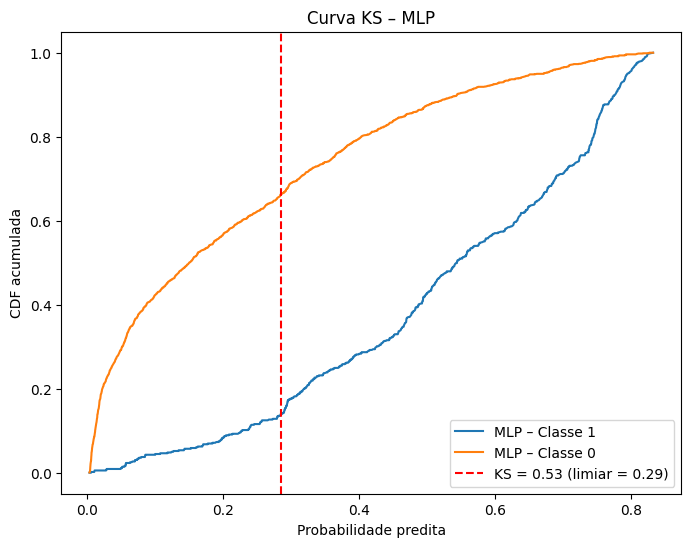

Modelo 'XGBoost' do Fold 1 salvo como '../models/XGBoost_fold_1_model.joblib'
XGBoost | Acurácia = 0.7979 | AUC = 0.8470


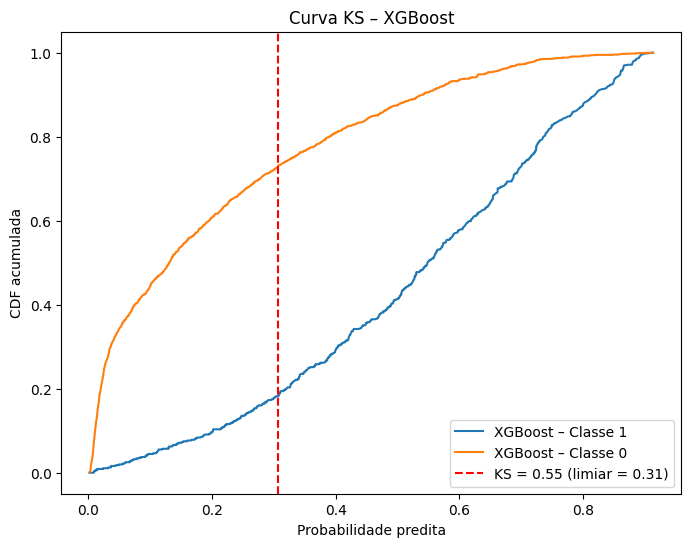

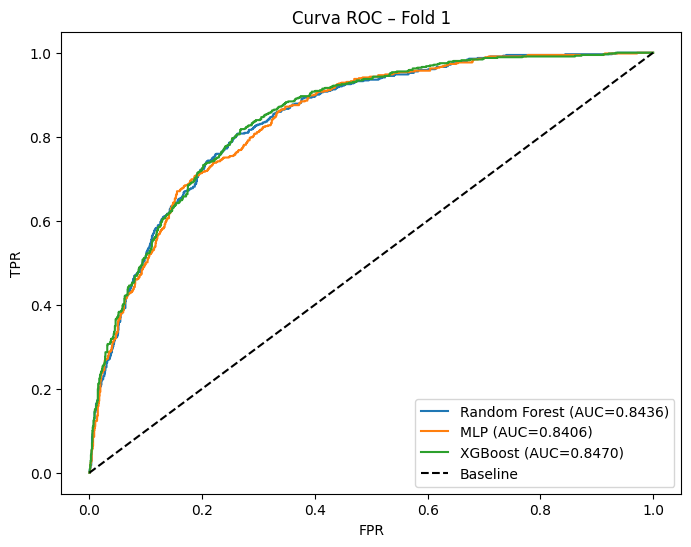

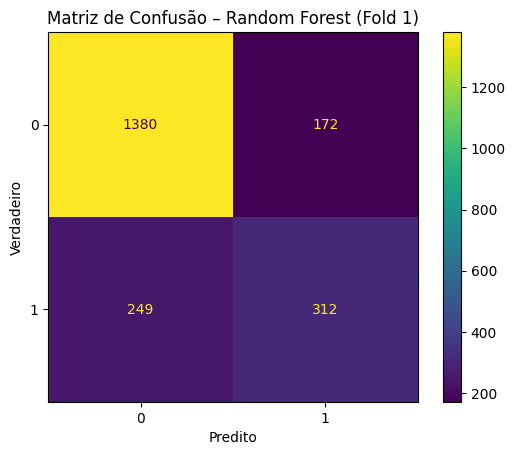

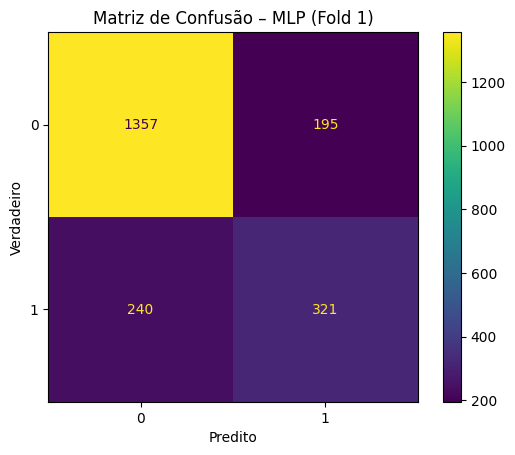

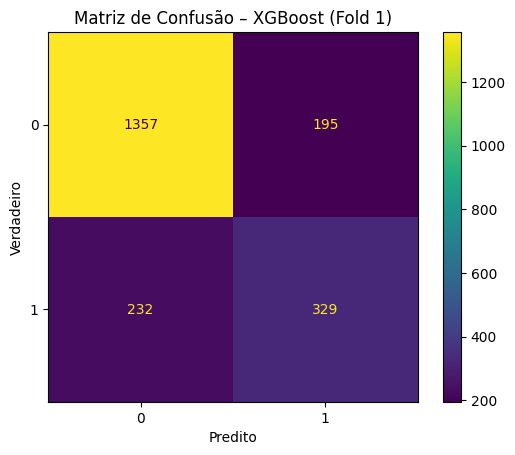


=== Fold 2 ===
Modelo 'Random Forest' do Fold 2 salvo como '../models/Random Forest_fold_2_model.joblib'
Random Forest | Acurácia = 0.7686 | AUC = 0.8371


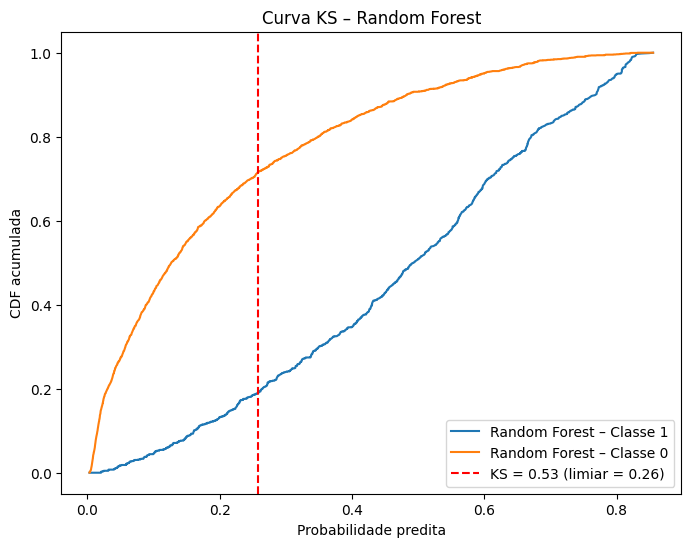

Modelo 'MLP' do Fold 2 salvo como '../models/MLP_fold_2_model.joblib'
MLP | Acurácia = 0.7803 | AUC = 0.8362


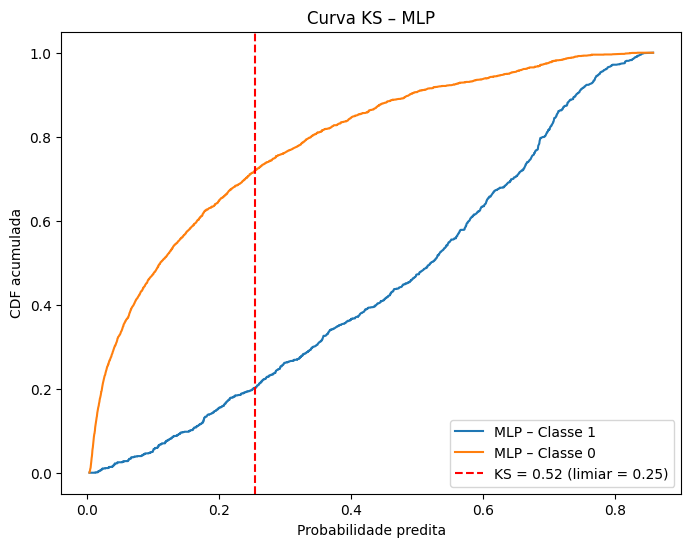

Modelo 'XGBoost' do Fold 2 salvo como '../models/XGBoost_fold_2_model.joblib'
XGBoost | Acurácia = 0.7720 | AUC = 0.8405


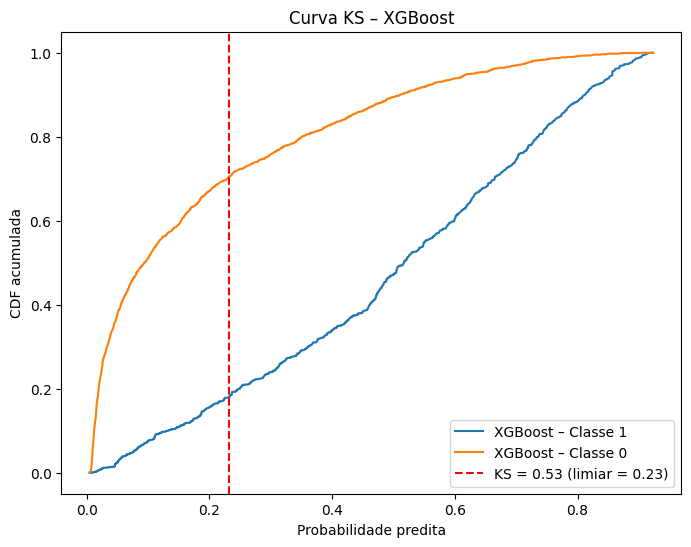

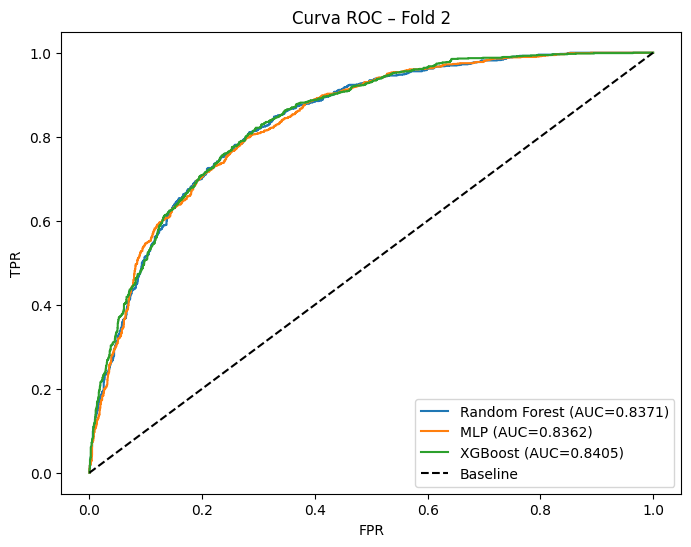

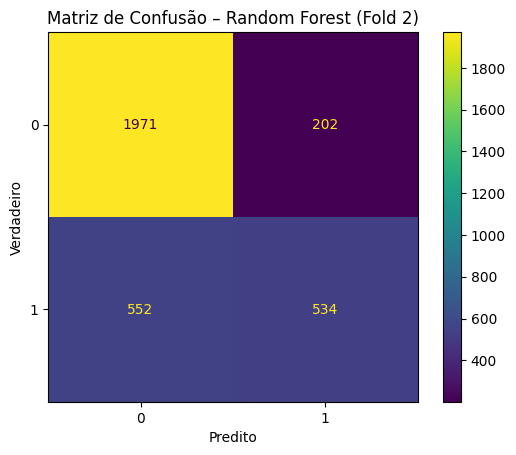

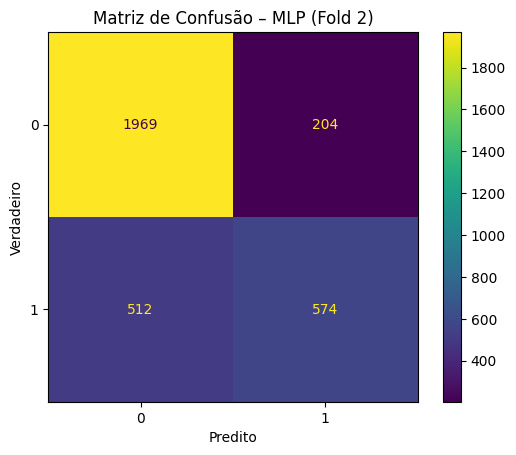

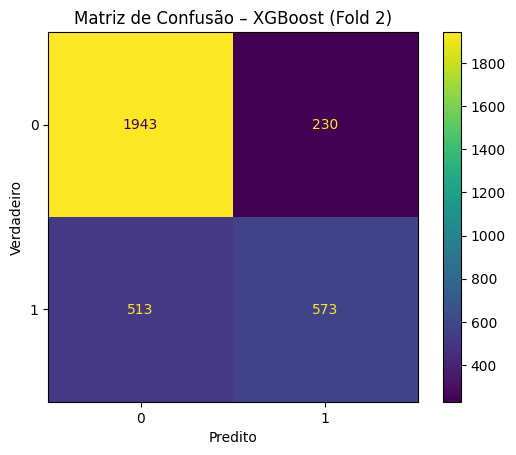


=== Fold 3 ===
Modelo 'Random Forest' do Fold 3 salvo como '../models/Random Forest_fold_3_model.joblib'
Random Forest | Acurácia = 0.8012 | AUC = 0.8494


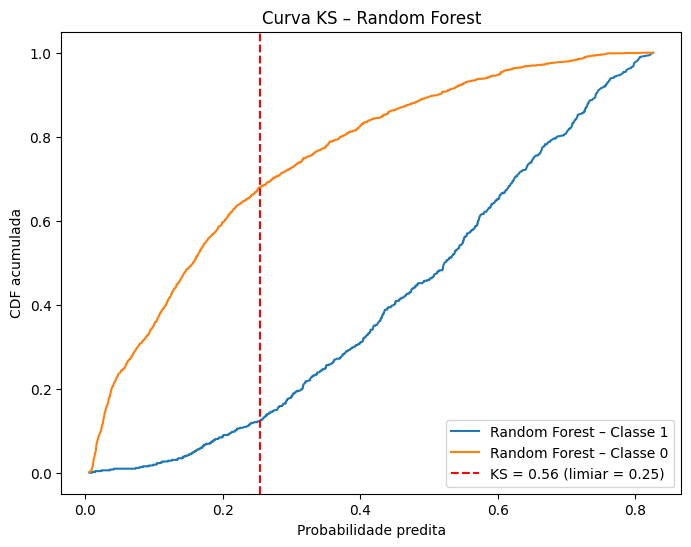

Modelo 'MLP' do Fold 3 salvo como '../models/MLP_fold_3_model.joblib'
MLP | Acurácia = 0.7951 | AUC = 0.8474


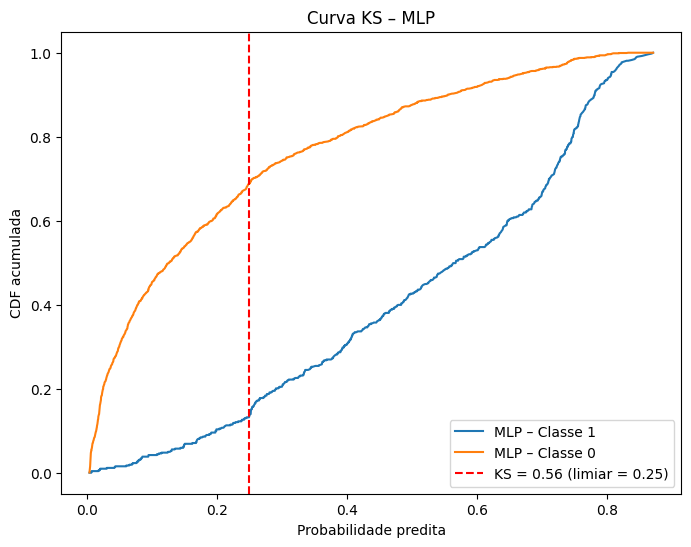

Modelo 'XGBoost' do Fold 3 salvo como '../models/XGBoost_fold_3_model.joblib'
XGBoost | Acurácia = 0.8038 | AUC = 0.8506


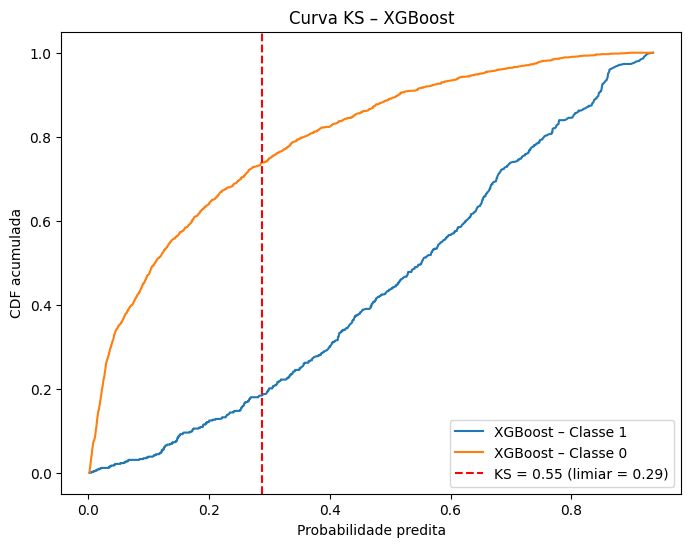

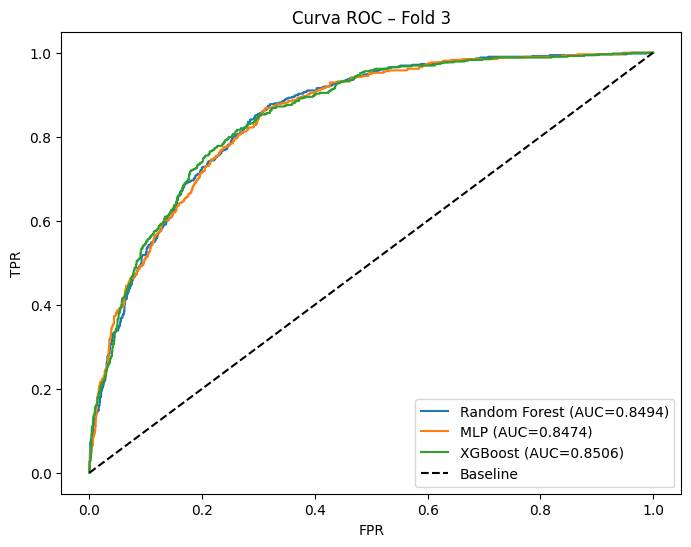

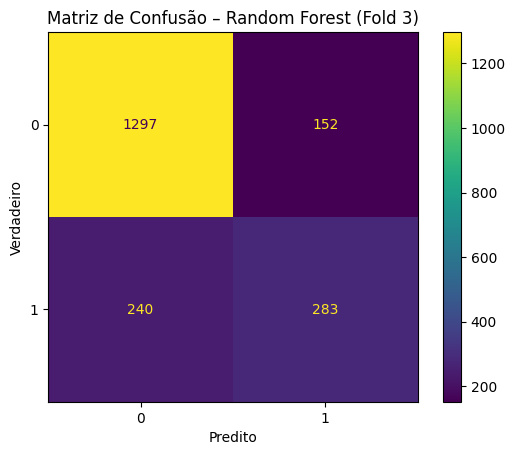

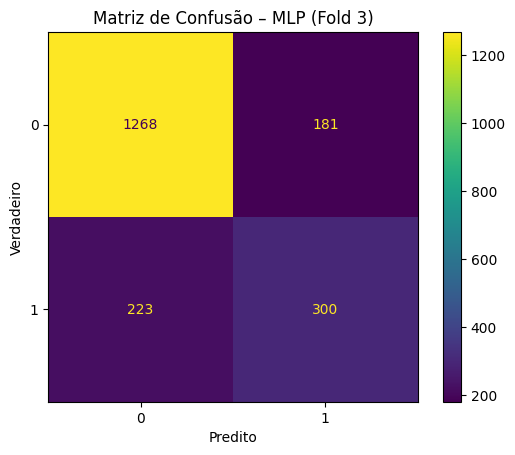

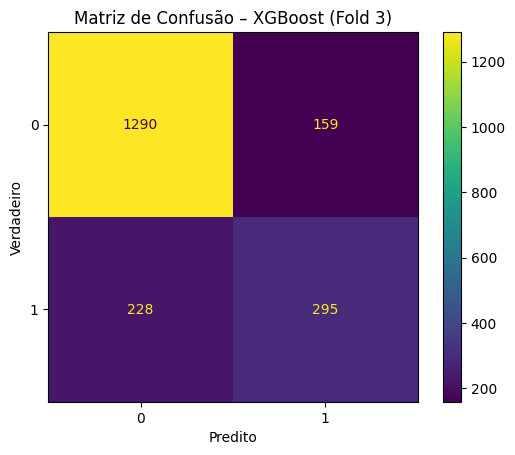

In [9]:
# Função para plotar a curva KS de um modelo
import os


def plot_ks(probabilities, y_true, model_name):
    """
    Plota a curva KS para um modelo.
    
    Parâmetros:
    - probabilities: array com as probabilidades preditas para a classe positiva.
    - y_true: array/Series com os rótulos reais (1D).
    - model_name: nome do modelo (string) para identificação no gráfico.
    """
    pos_probs = probabilities[y_true == 1]
    neg_probs = probabilities[y_true == 0]
    
    thresholds = np.sort(np.unique(np.concatenate((pos_probs, neg_probs))))
    pos_cdf = [np.mean(pos_probs <= t) for t in thresholds]
    neg_cdf = [np.mean(neg_probs <= t) for t in thresholds]
    
    differences = np.abs(np.array(pos_cdf) - np.array(neg_cdf))
    ks_stat    = np.max(differences)
    ks_idx     = np.argmax(differences)
    ks_thresh  = thresholds[ks_idx]
    
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, pos_cdf, label=f'{model_name} – Classe 1')
    plt.plot(thresholds, neg_cdf, label=f'{model_name} – Classe 0')
    plt.axvline(x=ks_thresh, color='red', linestyle='--',
                label=f'KS = {ks_stat:.2f} (limiar = {ks_thresh:.2f})')
    plt.xlabel('Probabilidade predita')
    plt.ylabel('CDF acumulada')
    plt.title(f'Curva KS – {model_name}')
    plt.legend(loc='best')
    plt.show()

X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_val)
X_test_df  = pd.DataFrame(X_test)

y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_val)
y_test_df  = pd.DataFrame(y_test)

models = {
    "Random Forest": RandomForestClassifier(random_state=42, **best_rf_params),
    "MLP":           MLPClassifier(random_state=42, **best_mlp_params),
    "XGBoost":       XGBClassifier(
                         random_state=42,
                         use_label_encoder=False,
                         eval_metric='logloss',
                         **best_xgb_params
                     )
}

folds = [
    {
        "X_train": pd.concat([X_train_df, X_valid_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_train_df, y_valid_df], axis=0).reset_index(drop=True),
        "X_test":  X_test_df.reset_index(drop=True),
        "y_test":  y_test_df.reset_index(drop=True)
    },
    {
        "X_train": pd.concat([X_valid_df, X_test_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_valid_df, y_test_df], axis=0).reset_index(drop=True),
        "X_test":  X_train_df.reset_index(drop=True),
        "y_test":  y_train_df.reset_index(drop=True)
    },
    {
        "X_train": pd.concat([X_test_df, X_train_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_test_df, y_train_df], axis=0).reset_index(drop=True),
        "X_test":  X_valid_df.reset_index(drop=True),
        "y_test":  y_valid_df.reset_index(drop=True)
    }
]

# --- Configuração para salvar os modelos ---
SAVE_DIR = '../models/' # Nome da pasta onde os modelos serão salvos
os.makedirs(SAVE_DIR, exist_ok=True) # Cria a pasta se ela não existir. exist_ok=True evita erro se a pasta já existe.
# ------------------------------------------

for i, fold in enumerate(folds, start=1):
    X_tr = fold["X_train"]
    y_tr = fold["y_train"].squeeze().values.ravel()
    X_te = fold["X_test"]
    y_te = fold["y_test"].squeeze().values.ravel()

    roc_data = {}
    cm_data  = {}

    print(f"\n=== Fold {i} ===")
    for name, model in models.items():
        model.fit(X_tr, y_tr)

        # Nome base do arquivo para o modelo e fold
        base_filename = f'{name}_fold_{i}_model.joblib'
        # Junta o diretório com o nome do arquivo
        full_path = os.path.join(SAVE_DIR, base_filename)

        # Salvar o modelo treinado para este fold no diretório especificado
        joblib.dump(model, full_path)
        print(f"Modelo '{name}' do Fold {i} salvo como '{full_path}'")
        
        y_pred  = model.predict(X_te)
        y_proba = model.predict_proba(X_te)[:, 1]

        accuracy = accuracy_score(y_te, y_pred)

        fpr, tpr, _ = roc_curve(y_te, y_proba, pos_label=1)
        roc_auc = auc(fpr, tpr)
        roc_data[name] = (fpr, tpr, roc_auc)

        print(f"{name} | Acurácia = {accuracy:.4f} | AUC = {roc_auc:.4f}") # Adicionado Acurácia na saída

        plot_ks(y_proba, y_te, name)

        cm = confusion_matrix(y_te, y_pred, labels=[0,1])
        cm_data[name] = cm

    plt.figure(figsize=(8,6))
    for name, (fpr, tpr, auc_) in roc_data.items():
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_:.4f})")
    plt.plot([0,1], [0,1], 'k--', label="Baseline")
    plt.title(f"Curva ROC – Fold {i}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.show()

    for name, cm in cm_data.items():
        fig, ax = plt.subplots()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(ax=ax)
        ax.set_title(f"Matriz de Confusão – {name} (Fold {i})")
        plt.xlabel("Predito"); plt.ylabel("Verdadeiro")
        plt.show()

c:\Users\hyggo\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


<Figure size 1000x600 with 0 Axes>

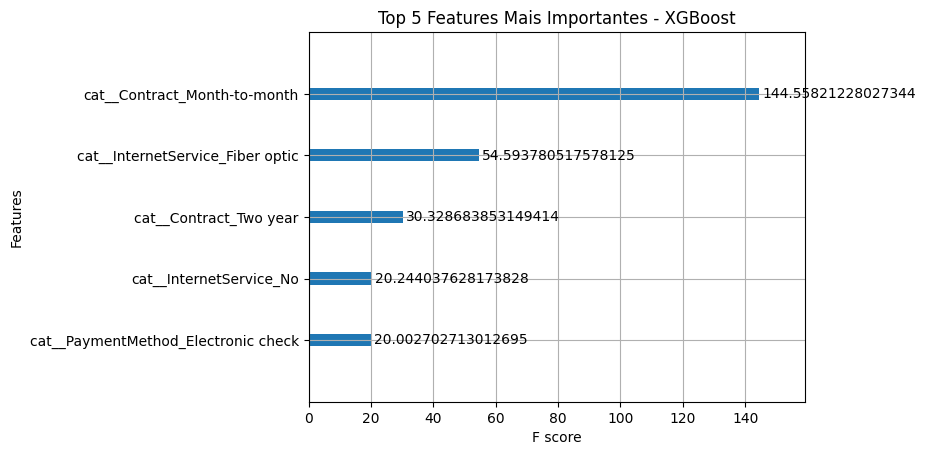

In [10]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

X_train = pd.concat([X_train_df, X_valid_df], axis=0).reset_index(drop=True)
y_train = pd.concat([y_train_df, y_valid_df], axis=0).reset_index(drop=True)
X_test =  X_test_df.reset_index(drop=True)
y_test =  y_test_df.reset_index(drop=True)
 
xgb_model = XGBClassifier(
                         random_state=42,
                         use_label_encoder=False,
                         eval_metric='logloss',
                         **best_xgb_params
                     ).fit(X_train,y_train)

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=5, importance_type='gain')
plt.title('Top 5 Features Mais Importantes - XGBoost')
plt.show()


C:\Users\hyggo\AppData\Local\Temp\ipykernel_9220\557982351.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)



Top 5 Features mais importantes (Random Forest):
                             Feature  Importância
1                        num__tenure     0.175578
12      cat__Contract_Month-to-month     0.164938
3                  num__TotalCharges     0.133341
2                num__MonthlyCharges     0.111207
10  cat__InternetService_Fiber optic     0.087883


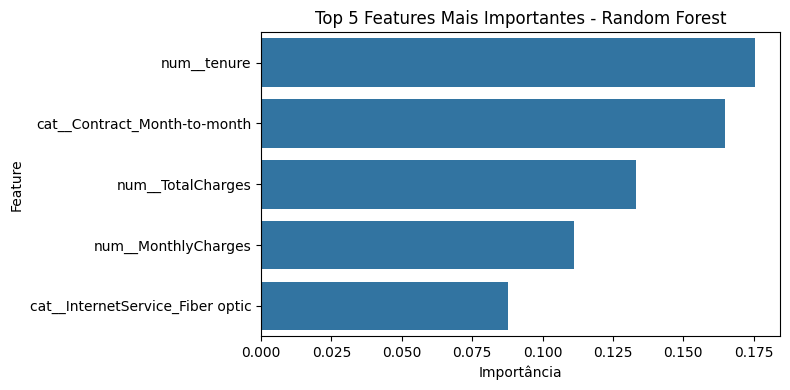

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Treinamento do modelo
rf_model = RandomForestClassifier(random_state=42, **best_rf_params)
rf_model.fit(X_train, y_train)

# Previsão
y_pred_rf = rf_model.predict(X_test)


# ==========================
# Top 5 Features Mais Importantes
# ==========================

# Certifique-se de que você tem os nomes das features originais
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"feature_{i}" for i in range(X_train.shape[1])]

# Obter importâncias
importancias = rf_model.feature_importances_

# Criar DataFrame
df_importancia_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importância': importancias
})

# Ordenar e pegar top 5
top5_rf = df_importancia_rf.sort_values(by='Importância', ascending=False).head(5)

# Exibir tabela
print("\nTop 5 Features mais importantes (Random Forest):")
print(top5_rf)

# Plotar
plt.figure(figsize=(8, 4))
sns.barplot(x='Importância', y='Feature', data=top5_rf)
plt.title('Top 5 Features Mais Importantes - Random Forest')
plt.tight_layout()
plt.show()


c:\Users\hyggo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Top 5 Features mais importantes (MLP - Permutation Importance):
                             Feature  Importância
1                        num__tenure     0.040464
10  cat__InternetService_Fiber optic     0.017037
2                num__MonthlyCharges     0.008235
12      cat__Contract_Month-to-month     0.007525
9           cat__InternetService_DSL     0.003975


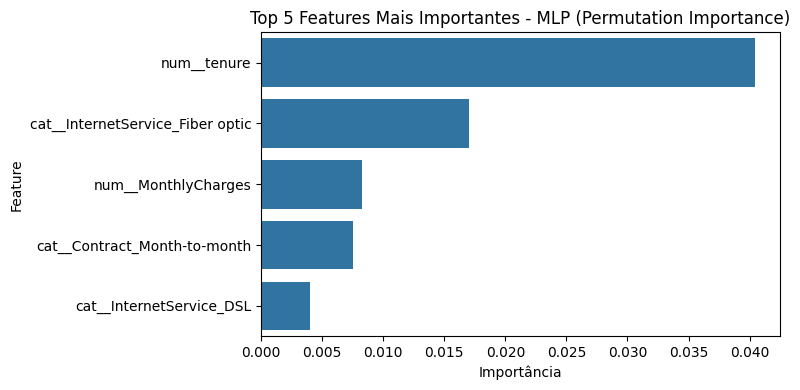

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Treinamento com dados padronizados (importante para MLP) ---
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar modelo
mlp_model = MLPClassifier(random_state=42, **best_mlp_params)
mlp_model.fit(X_train_scaled, y_train)

# Previsões
y_pred_mlp = mlp_model.predict(X_test_scaled)

# ================================
# Importância por Permutação
# ================================

# Calcular importâncias no conjunto de teste
result = permutation_importance(mlp_model, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Pegar nomes das features
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"feature_{i}" for i in range(X_train.shape[1])]

# Criar DataFrame com importâncias
df_importancia_mlp = pd.DataFrame({
    'Feature': feature_names,
    'Importância': result.importances_mean
})

# Top 5
top5_mlp = df_importancia_mlp.sort_values(by='Importância', ascending=False).head(5)

# Exibir
print("\nTop 5 Features mais importantes (MLP - Permutation Importance):")
print(top5_mlp)

# Plotar
plt.figure(figsize=(8, 4))
sns.barplot(x='Importância', y='Feature', data=top5_mlp)
plt.title('Top 5 Features Mais Importantes - MLP (Permutation Importance)')
plt.tight_layout()
plt.show()



In [ ]:
import joblib
import os
import numpy as np
import pandas as pd

from sklearn.inspection import permutation_importance

# --- Configuração do diretório onde os modelos foram salvos ---
SAVE_DIR = '../models/' # Deve ser o MESMO nome de pasta usado para salvar!
# -------------------------------------------------------------

# --- Especificar qual Fold carregar e quais Modelos analisar ---
fold_to_load = 1 # Queremos carregar apenas modelos do Fold 1
# Lista dos nomes dos modelos que foram salvos
model_names_to_load = ["Random Forest", "MLP", "XGBoost"] # <-- Corrigido para os nomes dos modelos
# -------------------------------------------------------------


# --- SUBSTITUA ESTA LINHA PELA SUA LISTA REAL DE 19 NOMES DE FEATURES ---
REAL_FEATURE_NAMES = feature_column_names
# ----------------------------------------------------------------------


loaded_models = {} # Dicionário para armazenar os modelos carregados

print(f"Tentando carregar modelos do Fold {fold_to_load} da pasta '{SAVE_DIR}'...")

# Verifica se o diretório de salvamento existe
if not os.path.isdir(SAVE_DIR):
    print(f"Erro: O diretório '{SAVE_DIR}' não foi encontrado.")
else:
    for name in model_names_to_load:
        # Constrói o nome do arquivo exatamente como foi salvo
        base_filename = f'{name}_fold_{fold_to_load}_model.joblib'
        full_path = os.path.join(SAVE_DIR, base_filename)

        if os.path.exists(full_path):
            try:
                model = joblib.load(full_path)
                loaded_models[name] = model
                print(f"Modelo '{name}' do Fold {fold_to_load} carregado com sucesso.")
            except Exception as e:
                print(f"Erro ao carregar o modelo '{name}' de '{full_path}': {e}")
        else:
            print(f"Arquivo não encontrado para o modelo '{name}' no caminho '{full_path}'. Pulando.")

# --- Analisar e exibir as top 5 features para cada modelo carregado ---
print("\n--- Análise das Features Mais Importantes ---")

if not loaded_models:
    print("Nenhum modelo foi carregado com sucesso para análise.")
else:
    for name, model in loaded_models.items():
        print(f"\nModelo: {name}")

        # Verifica se o modelo possui o atributo feature_importances_
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_

            # Verifica se o número de importâncias corresponde ao número de nomes de features fornecidos
            if len(importances) != len(REAL_FEATURE_NAMES):
                print(f"Erro: O número de importâncias ({len(importances)}) não corresponde ao número de nomes de features fornecidos ({len(REAL_FEATURE_NAMES)}).")
                print("Não é possível mostrar os nomes corretos das features.")
                print("Por favor, atualize a lista REAL_FEATURE_NAMES com os nomes corretos e o número exato de features (19).")
            elif len(importances) == 0:
                 print("Não há importâncias de features disponíveis para este modelo.")
            else:
                # Cria pares (importância, nome da feature) e ordena
                feature_importance_pairs = list(zip(importances, REAL_FEATURE_NAMES))
                feature_importance_pairs.sort(key=lambda x: x[0], reverse=True) # Ordena por importância, decrescente

                # Pega as top N features (N=5)
                top_n = 5
                top_features = feature_importance_pairs[:top_n]

                print(f"Top {top_n} Features Mais Importantes:")
                # Verifica se a importância máxima é > 0 antes de imprimir
                if top_features and top_features[0][0] > 0:
                    for score, feature in top_features:
                        print(f"  - {feature}: {score:.4f}")
                else:
                     print("  Não foi possível determinar importâncias de features significativas (todas são zero ou insignificantes).")


        # Lida com modelos que não possuem feature_importances_ (como MLPs)
        elif isinstance(model, MLPClassifier):
             print("Nota: Modelos MLP não possuem um atributo direto '.feature_importances_'.")
             print("  Para obter a importância de features para MLPs, são necessárias técnicas adicionais")
             print("  (como Permutation Importance, SHAP, LIME, etc.).")
        else:
             print("Não foi possível obter importâncias de features para este tipo de modelo.")

Tentando carregar modelos do Fold 1 da pasta '../models/'...
Modelo 'Random Forest' do Fold 1 carregado com sucesso.
Modelo 'MLP' do Fold 1 carregado com sucesso.
Modelo 'XGBoost' do Fold 1 carregado com sucesso.

--- Análise das Features Mais Importantes ---

Modelo: Random Forest
Top 5 Features Mais Importantes:
  - num__tenure: 0.1756
  - cat__Contract_Month-to-month: 0.1649
  - num__TotalCharges: 0.1333
  - num__MonthlyCharges: 0.1112
  - cat__InternetService_Fiber optic: 0.0879

Modelo: MLP
Nota: Modelos MLP não possuem um atributo direto '.feature_importances_'.
  Para obter a importância de features para MLPs, são necessárias técnicas adicionais
  (como Permutation Importance, SHAP, LIME, etc.).

Modelo: XGBoost
Top 5 Features Mais Importantes:
  - cat__Contract_Month-to-month: 0.3833
  - cat__InternetService_Fiber optic: 0.1448
  - cat__Contract_Two year: 0.0804
  - cat__InternetService_No: 0.0537
  - cat__PaymentMethod_Electronic check: 0.0530
